In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101

import torchneuromorphic


/tmp/ipykernel_9846/2154813661.py:45: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torchneuromorphic-0.3.7-py3.8.egg/torchneuromorphic/ntidigits/ntidigits_dataloaders.py:79: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torchneuromorphic-0.3.7-py3.8.egg/torchneuromorphic/ntidigits/ntidigits_dataloaders.py:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torchneuromorphic-0.3.7-py3.8.egg/torchneuromorphic/ntidigits/ntidigits_dataloaders.py:99: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torchneuromorphic-0.3.7-py3.8.egg/torchneuromorphic/ntidigits/ntidigits_dataloaders.py:101: SyntaxWarning: "is" with a literal. Did you mean "=="?
/home/bhkim003/anaconda3/envs/aedat2/lib/python3.8/site-packages/torchneuromorphic-0.3.7-py3.8.egg/torchneuromorphic/ntidigits/ntidigits_dataloaders.py:79:

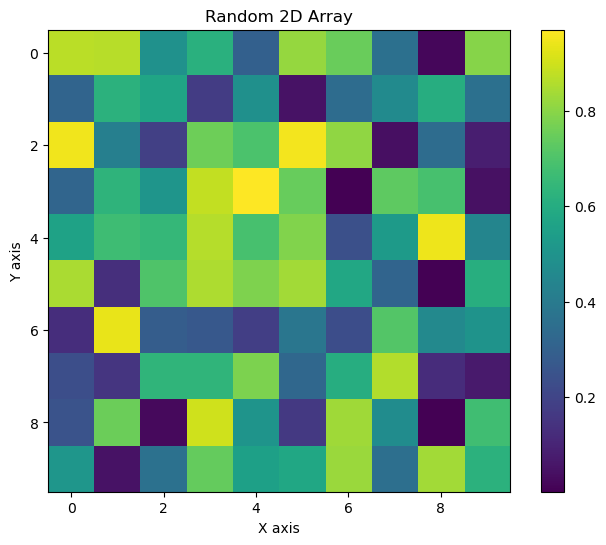

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
 # dvs 데이터 시각화 코드
 ##############################################################################################
            # mapping = {
            #     0: 'Hand Clapping',
            #     1: 'Right Hand Wave',
            #     2: 'Left Hand Wave',
            #     3: 'Right Arm CW',
            #     4: 'Right Arm CCW',
            #     5: 'Left Arm CW',
            #     6: 'Left Arm CCW',
            #     7: 'Arm Roll',
            #     8: 'Air Drums',
            #     9: 'Air Guitar',
            #     10: 'Other'
            # }
def dvs_visualization(inputs, labels, TIME, BATCH):
            
    what_input = random.randint(0, BATCH - 1)
    inputs_for_view = inputs.permute(1, 0, 2, 3, 4)
    for i in range(TIME):
        # 예시 데이터 생성
        data1 = inputs_for_view[what_input][i][0].numpy()  # torch tensor를 numpy 배열로 변환
        data2 = inputs_for_view[what_input][i][1].numpy()  # torch tensor를 numpy 배열로 변환

        # 데이터 플로팅
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1행 2열의 subplot 생성

        # 첫 번째 subplot에 데이터1 플로팅
        im1 = axs[0].imshow(data1, cmap='viridis', interpolation='nearest')
        axs[0].set_title(f'Input 1\nLabel: {labels[what_input]}')  # 라벨값 맵핑하여 제목에 추가
        axs[0].set_xlabel('X axis')
        axs[0].set_ylabel('Y axis')
        axs[0].grid(False)
        fig.colorbar(im1, ax=axs[0])  # Color bar 추가

        # 두 번째 subplot에 데이터2 플로팅
        im2 = axs[1].imshow(data2, cmap='viridis', interpolation='nearest')
        axs[1].set_title(f'Input 2\nLabel: {labels[what_input]}')  # 라벨값 맵핑하여 제목에 추가
        axs[1].set_xlabel('X axis')
        axs[1].set_ylabel('Y axis')
        axs[1].grid(False)
        fig.colorbar(im2, ax=axs[1])  # Color bar 추가

        plt.tight_layout()  # subplot 간 간격 조정
        plt.show()
    sys.exit("종료")

######################################################################################################

In [4]:
import torch
from torch.utils.data import DataLoader
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask, dvs128_gesture
root='/data2/gesture'
train_set = dvs128_gesture.DVS128Gesture(root, data_type='frame', duration=1000000, train=True)
for i in range(5):
    x, y = train_set[i]
    print(f'x[{i}].shape=[T, C, H, W]={x.shape}')
train_data_loader = DataLoader(train_set, collate_fn=pad_sequence_collate, batch_size=5)
for x, y, x_len in train_data_loader:
    print(f'x.shape=[N, T, C, H, W]={tuple(x.shape)}')
    print(f'x_len={x_len}')
    mask = padded_sequence_mask(x_len)  # mask.shape = [T, N]
    print(f'mask=\n{mask.t().int()}')
    break

The directory [/data2/gesture/duration_1000000] already exists.
x[0].shape=[T, C, H, W]=(6, 2, 128, 128)
x[1].shape=[T, C, H, W]=(6, 2, 128, 128)
x[2].shape=[T, C, H, W]=(5, 2, 128, 128)
x[3].shape=[T, C, H, W]=(5, 2, 128, 128)
x[4].shape=[T, C, H, W]=(7, 2, 128, 128)
x.shape=[N, T, C, H, W]=(5, 7, 2, 128, 128)
x_len=tensor([6, 6, 5, 5, 7])
mask=
tensor([[1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1]], dtype=torch.int32)
